In [162]:
# Loading packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import sys
import matplotlib.colors as mcolors
from Levenshtein import distance


import torch
import torch.nn as nn
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

--------------

In [163]:
# Load only IC50 data
df = pd.read_csv("./data/IC50_df.csv")
df.head(1)

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,5800.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak


> To check if we can create a Linear Regression Model for our CDK-Ligand relations we will start by creating a model on the CDK with the most data.

In [164]:
# copy the df
df_CDK = df.copy()

# list one CDK 
df_CDK.groupby("Target Name")["BindingDB Ligand Name"].nunique().sort_values(ascending=False).head(1)

Target Name
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1    1156
Name: BindingDB Ligand Name, dtype: int64

> As we remember from our data preprocessing the distrubtion of IC50 values were heavy tailed and we will there create the model on the log transformed IC50 values.

In [165]:
# make the column IC50 as the log value of that column
df_CDK["IC50 log"] = np.log(df_CDK["IC50 (nM)"].values)
# drop the rows with nan values
df_CDK = df_CDK.dropna(subset=["IC50 log"])

In [166]:
df_CDK.isna().sum()

Ligand SMILES                                                  0
BindingDB Ligand Name                                          0
Target Name                                                    0
Target Source Organism According to Curator or DataSource    265
IC50 (nM)                                                      0
BindingDB Target Chain Sequence                                0
UniProt (SwissProt) Entry Name of Target Chain                19
IC50_class                                                     0
IC50 log                                                       0
dtype: int64

In [167]:
df_CDK.shape

(6486, 9)

In [168]:
# Take one CDK reindex
ligands_df_CDK2_G1 = df_CDK[df_CDK["Target Name"] == "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"]
# reset index
ligands_df_CDK2_G1.reset_index(drop=True, inplace=True)
ligands_df_CDK2_G1.shape # 1206, 8

(1131, 9)

___

### 2. Vectorization of the SMILES molecules using RDKit

> In order to make use of the SMILES Ligand strings as features for our model we will have to convert to SMILES ligand string to a numerical vector. There are many ways to this but one industry standard is to use The Morgan Fingerprint algorithm. We will do it through the RDKit library.
> Initially we have to create a Mol Object from RDKit - this allows us to create the numerical vectors but also allowds for some nice pictures of the ligands. :))

In [169]:
# Fingerprints
PandasTools.AddMoleculeColumnToFrame(ligands_df_CDK2_G1,'Ligand SMILES','Molecule')
ligands_df_CDK2_G1[["Ligand SMILES","Molecule"]].head(1)

/opt/anaconda3/lib/python3.12/site-packages/rdkit/Chem/PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Ligand SMILES,Molecule
0,CC(=O)Nc1cccc2-c3[nH]nc(c3C(=O)c12)-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x325e765e0>


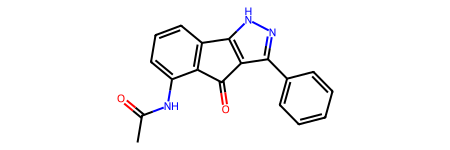

In [170]:
ligands_df_CDK2_G1.iloc[0]["Molecule"]

In [171]:
# are there nans
ligands_df_CDK2_G1.Molecule.isna().sum()

0

### 2.1 Let us create a function to create Morgan Fingeprints based on the Mol Objects

[0 0 0 ... 0 0 0]


[21:33:33] DEPRECATION WARNING: please use MorganGenerator


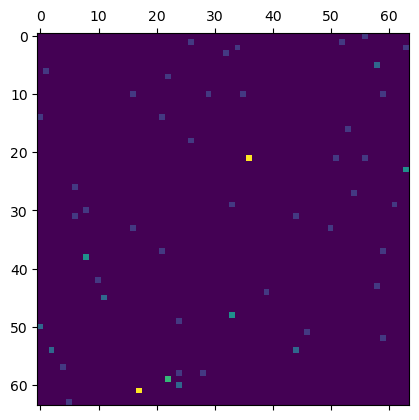

In [172]:
# vectorize the ligands

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     

# visualize one example fingerprint
fp = mol2fp(Chem.MolFromSmiles(ligands_df_CDK2_G1.loc[67,"Ligand SMILES"]))
print(fp)
plt.matshow(fp.reshape(64, -1), cmap="viridis")

As we can see the fingerprints are quite sparse, but let's wait with this until later ;)) 


In [173]:
# find all the different values in the fp array
np.unique(fp)

array([0, 1, 2, 3, 4, 6], dtype=int8)

`TODO` : Describe how Morgan fingerprint works.


In [174]:
# Vectorize all the ligands
ligands_df_CDK2_G1["FPs"] = ligands_df_CDK2_G1.Molecule.apply(mol2fp)

[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerator
[21:33:33] DEPRECATION WARNING: please use MorganGenerat

> Creating the features and targets for the train and test set.

In [202]:
test = ligands_df_CDK2_G1.sample(frac=0.2, random_state=42)
train = ligands_df_CDK2_G1.drop(test.index)

X_train = np.stack(train["FPs"].values)
y_train = train["IC50 log"].values

X_test = np.stack(test["FPs"].values)
y_test = test["IC50 log"].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


feature_select = VarianceThreshold(threshold=0.05)  # TODO: find the best threshold
scaler = StandardScaler()

X_train = feature_select.fit_transform(X_train)
X_train = sm.add_constant(X_train)
print(X_train[0])

X_test = feature_select.transform(X_test)
X_test = sm.add_constant(X_test)



X_train shape: (905, 4096)
y_train shape: (905,)
X_test shape: (226, 4096)
y_test shape: (226,)
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 4. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


> Now we create the linear regression model and train it on the training set.

In [203]:
model = sm.OLS(y_train, X_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     15.28
Date:                Sat, 07 Dec 2024   Prob (F-statistic):          8.44e-169
Time:                        21:42:49   Log-Likelihood:                -1300.2
No. Observations:                 905   AIC:                             3134.
Df Residuals:                     638   BIC:                             4418.
Df Model:                         266                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4663      0.834     13.743      0.000       9.828      13.105
x1            -0.0350      0.454     -0.077      0.939      -0.926       0.856
x2            -0.1658      0.354     -0.468      0.640      -0.862       0.530
x3            -0.8575      0.314     -2.735      0.006      -1.473      -0.242
x4            -2.2649      2.024     -1.119      0.264      -6.239       1.709
x5             5.4393      1.254      4.336      0.000       2.976       7.903
x6             0.4785      0.578      0.828      0.408      -0.657       1.614
x7             0.4994      0.539      0.927      0.354      -0.558       1.557
x8             0.6590      0.425      1.550      0.122      -0.176       1.494
x9            -0.0391      0.667     -0.059      0.953      -1.348       1.270
x10            0.3022      0.591      0.512      0.609      -0.858       1.462
x11           -1.0052      0.651     -1.545      0.123      -2.283       0.273
x12            0.6999      1.124      0.623      0.534      -1.507       2.906
x13           -0.6326      0.197     -3.211      0.001      -1.020      -0.246
x14            0.6436      0.697      0.924      0.356      -0.724       2.011
x15           -0.9245      0.834     -1.109      0.268      -2.562       0.712
x16            1.3583      0.845      1.608      0.108      -0.300       3.017
x17           -0.6046      0.640     -0.944      0.345      -1.862       0.652
x18            1.0458      0.923      1.133      0.257      -0.766       2.858
x19           -0.5320      1.779     -0.299      0.765      -4.026       2.962
x20            4.0748      4.398      0.927      0.354      -4.561      12.710
x21            0.0350      1.058      0.033      0.974      -2.043       2.113
x22           -1.3117      0.620     -2.117      0.035      -2.529      -0.095
x23           -0.2399      1.265     -0.190      0.850      -2.723       2.244
x24            0.2892      0.413      0.700      0.484      -0.522       1.100
x25           -0.0880      0.593     -0.148      0.882      -1.253       1.077
x26            1.3647      0.548      2.489      0.013       0.288       2.441
x27            0.5791      0.652      0.888      0.375      -0.702       1.860
x28           -0.9793      0.599     -1.634      0.103      -2.156       0.198
x29            1.5908      1.255      1.267      0.206      -0.874       4.056
x30           -0.3555      0.726     -0.490      0.625      -1.781       1.070
x31           -0.0922      0.348     -0.265      0.791      -0.775       0.591
x32           -0.5480      0.655     -0.837      0.403      -1.834       0.738
x33            0.3750      0.562      0.668      0.505      -0.728       1.478
x34            0.6788      1.076      0.631      0.528      -1.435       2.792
x35           -0.0127      0.280     -0.045      0.964      -0.563       0.537
x3

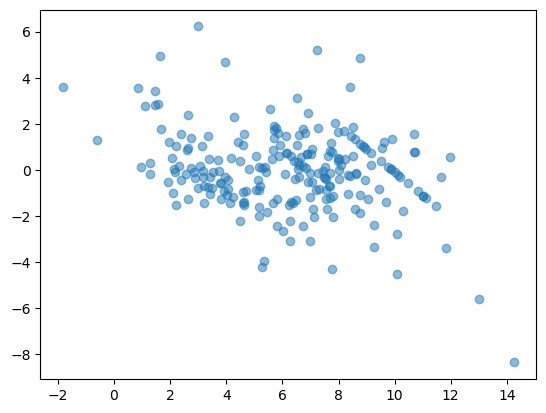

In [204]:
# Residuals plot
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), alpha=0.5)

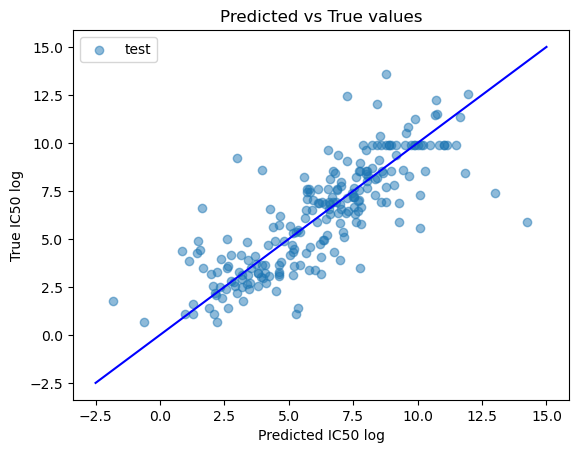

In [205]:
plt.scatter(model.predict(X_test), y_test, alpha=0.5, label="test")
plt.plot([-2.5, 15], [-2.5, 15], c="b")
plt.xlabel("Predicted IC50 log")
plt.ylabel("True IC50 log")
plt.title("Predicted vs True values")
plt.legend()
plt.show()


In [195]:
def predict_aff(model, ligand : str):
    fp = mol2fp(Chem.MolFromSmiles(ligand))

    X_1_sample = np.stack([fp])

    print(X_1_sample)
    X_1_sample = feature_select.transform(X_1_sample)
    X_1_sample = X_1_sample.flatten()

    # Add a 1 as the head of the array

    X_1_sample = np.insert(X_1_sample, 0, 1)

    print(X_1_sample)
    print(X_1_sample.shape)

    pred = model.predict(X_1_sample)

    print(f"Predicted values of the IC50 log: {pred}")
    print(f"Non log values: {np.exp(pred)}")

    return pred

predict_aff(model, "CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1")

[[0 0 0 ... 0 0 0]]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0
 2 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 1 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 1 0 1 0]
(282,)
Predicted values of the IC50 log: [2.78409642]
Non log values: [16.18518659]


[21:39:55] DEPRECATION WARNING: please use MorganGenerator


array([2.78409642])

In [213]:
df_CDK[df_CDK["Target Name"] != "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"].iloc[5]["Ligand SMILES"]

'Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1'

[[0 0 0 ... 0 0 0]]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0
 2 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 1 0 1 0]
(282,)
Predicted values of the IC50 log: [3.3240373]
Non log values: [27.7722495]


[21:50:27] DEPRECATION WARNING: please use MorganGenerator


array([3.3240373])

In [216]:
predict_aff(model, "CCO")

[[0 0 0 ... 0 0 0]]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(282,)
Predicted values of the IC50 log: [10.68860028]
Non log values: [43853.08205866]


[21:52:32] DEPRECATION WARNING: please use MorganGenerator


array([10.68860028])